In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    ParameterGrid
)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix
)
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.base import clone
import xgboost as xgb
import shap


In [234]:
df = pd.read_csv("cirrhosis.csv")
df = df[df['Status'] != "CL"]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 393 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             393 non-null    int64  
 1   N_Days         393 non-null    int64  
 2   Status         393 non-null    object 
 3   Drug           293 non-null    object 
 4   Age            393 non-null    int64  
 5   Sex            393 non-null    object 
 6   Ascites        293 non-null    object 
 7   Hepatomegaly   293 non-null    object 
 8   Spiders        293 non-null    object 
 9   Edema          393 non-null    object 
 10  Bilirubin      393 non-null    float64
 11  Cholesterol    266 non-null    float64
 12  Albumin        393 non-null    float64
 13  Copper         291 non-null    float64
 14  Alk_Phos       293 non-null    float64
 15  SGOT           293 non-null    float64
 16  Tryglicerides  264 non-null    float64
 17  Platelets      382 non-null    float64
 18  Prothrombin    

In [235]:
df['Status'].value_counts()

Status
C    232
D    161
Name: count, dtype: int64

In [236]:
print(df.columns)

Index(['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites',
       'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
       'Prothrombin', 'Stage'],
      dtype='object')


In [237]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2 
TARGET_LABELS = {"C": "Survived", "D": "Died"}

if "Status_final" not in df.columns:
    df["Status_final"] = df["Status"].map(TARGET_LABELS)
df = df.drop(columns=["N_Days"])
df_bin = df[df["Status_final"].isin(["Survived", "Died"])].copy()
y_text = df_bin["Status_final"].copy()
y = (df_bin["Status_final"] == "Survived").astype(int)
X = df_bin.drop(columns=["Status_final", "Status", "ID"])

missing_per_col = X.isna().mean().sort_values(ascending=False)
frac_rows_with_any_missing = X.isna().any(axis=1).mean()
frac_features_with_missing = (missing_per_col > 0).mean()

print("Before Preprocessing")
print(f"Rows: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Fraction of rows with any missing values: {frac_rows_with_any_missing}")
print(f"Fraction of features with any missing values: {frac_features_with_missing}")
print("\nTop features by missing fraction:")
print(missing_per_col.head(40).to_frame("missing_frac"))

Before Preprocessing
Rows: 393
Features: 17
Fraction of rows with any missing values: 0.3435114503816794
Fraction of features with any missing values: 0.7058823529411765

Top features by missing fraction:
               missing_frac
Tryglicerides      0.328244
Cholesterol        0.323155
Copper             0.259542
SGOT               0.254453
Alk_Phos           0.254453
Drug               0.254453
Spiders            0.254453
Hepatomegaly       0.254453
Ascites            0.254453
Platelets          0.027990
Stage              0.015267
Prothrombin        0.005089
Edema              0.000000
Bilirubin          0.000000
Age                0.000000
Albumin            0.000000
Sex                0.000000


In [238]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 393 entries, 0 to 417
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Drug           293 non-null    object 
 1   Age            393 non-null    int64  
 2   Sex            393 non-null    object 
 3   Ascites        293 non-null    object 
 4   Hepatomegaly   293 non-null    object 
 5   Spiders        293 non-null    object 
 6   Edema          393 non-null    object 
 7   Bilirubin      393 non-null    float64
 8   Cholesterol    266 non-null    float64
 9   Albumin        393 non-null    float64
 10  Copper         291 non-null    float64
 11  Alk_Phos       293 non-null    float64
 12  SGOT           293 non-null    float64
 13  Tryglicerides  264 non-null    float64
 14  Platelets      382 non-null    float64
 15  Prothrombin    391 non-null    float64
 16  Stage          387 non-null    float64
dtypes: float64(10), int64(1), object(6)
memory usage: 55.3+ KB


In [239]:
# numerical features
num_cols = [
    "Age",
    "Bilirubin",
    "Cholesterol",
    "Albumin",
    "Copper",
    "Alk_Phos",
    "SGOT",
    "Tryglicerides",
    "Platelets",
    "Prothrombin"
]

# ordinal features
stage_col = ["Stage"]     # values: 1.0, 2.0, 3.0, 4.0 BUT make missing --> 0.0
edema_col = ["Edema"]     # ordinal, no missing

# categorical features
cat_cols = ["Sex", "Hepatomegaly", "Spiders", "Ascites", "Drug"]

# numerical - iterative imputer
num_pipeline = Pipeline(steps=[
    ("imputer", IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=20,
        random_state=0
    )),
    ("scaler", StandardScaler())
])

# ordinal:
#   STAGE missing --> 0.0, then scale. Already in float format
#   Edema, no missing, just scale. 	
#           N (no edema and no diuretic therapy for edema), 
#           S (edema present without diuretics, or edema resolved by diuretics), 
#           Y (edema despite diuretic therapy)

stage_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
    ("scaler", StandardScaler())
])

edema_pipeline = Pipeline(steps=[
    ("encoder", OrdinalEncoder(
        categories=[["N", "S", "Y"]],  # explicit order
        dtype=float
    )),
    ("scaler", StandardScaler())
])

# Categorical: impute missing as "Missing", then one-hot with an explicit Missing column
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("stage", stage_pipeline, stage_col),
        ("edema", edema_pipeline, edema_col),
        ("cat", cat_pipeline, cat_cols),
    ]
)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    shuffle=True,
    random_state=0
)

In [241]:
print("Training size:", X_train.shape)
print("Test size:", X_test.shape)

Training size: (314, 17)
Test size: (79, 17)


In [242]:
logreg_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(
        max_iter=10000,
        penalty="l2",
        solver="lbfgs"
    ))
])

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

C_grid = np.logspace(-6, 6, 13)

param_grid = {
    "clf__C": C_grid,
    "clf__class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"Best CV F1: {grid.best_score_:.3f}")

best_logreg = grid.best_estimator_
y_pred_test = best_logreg.predict(X_test)

test_f1 = f1_score(y_test, y_pred_test)
test_acc = accuracy_score(y_test, y_pred_test)

print("\nTest performance (Logistic Regression):")
print(f"F1 Score: {test_f1:.3f}")
print(f"Accuracy: {test_acc:.3f}")

Best params: {'clf__C': np.float64(0.0001), 'clf__class_weight': 'balanced'}
Best CV F1: 0.832

Test performance (Logistic Regression):
F1 Score: 0.788
Accuracy: 0.734


In [243]:
svm_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", SVC(
        probability=True,
        random_state=0
    ))
])

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

C_grid = np.logspace(-4, 4, 9)
gamma_grid = np.logspace(-5, 1, 7)

param_grid_svm = [
    {
        "clf__kernel": ["rbf"],
        "clf__C": C_grid,
        "clf__gamma": gamma_grid,
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf__kernel": ["linear"],
        "clf__C": C_grid,
        "clf__class_weight": [None, "balanced"]
    }
]

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

svm_grid.fit(X_train, y_train)

print("Best SVM params:", svm_grid.best_params_)
print(f"Best SVM CV F1: {svm_grid.best_score_:.3f}")

best_svm = svm_grid.best_estimator_
y_pred_test_svm = best_svm.predict(X_test)

test_f1_svm = f1_score(y_test, y_pred_test_svm)
test_acc_svm = accuracy_score(y_test, y_pred_test_svm)

print("\nTest Set Performance (SVM):")
print(f"F1 Score: {test_f1_svm:.3f}")
print(f"Accuracy: {test_acc_svm:.3f}")


Best SVM params: {'clf__C': np.float64(1.0), 'clf__class_weight': None, 'clf__gamma': np.float64(0.01), 'clf__kernel': 'rbf'}
Best SVM CV F1: 0.844

Test Set Performance (SVM):
F1 Score: 0.816
Accuracy: 0.759


In [244]:
rf_pipeline = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        random_state=0,
        class_weight="balanced",
        n_jobs=-1
    ))
])

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

n_estimators_grid = np.linspace(200, 800, 7, dtype=int)
max_depth_grid = [None, 3, 5, 7, 9]
max_features_grid = ["sqrt", "log2", 0.4, 0.6, 0.8]

param_grid_rf = {
    "clf__n_estimators": n_estimators_grid,
    "clf__max_depth": max_depth_grid,
    "clf__max_features": max_features_grid
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print(f"Best RF CV F1: {rf_grid.best_score_:.3f}")

best_rf = rf_grid.best_estimator_

y_pred_test_rf = best_rf.predict(X_test)

test_f1_rf = f1_score(y_test, y_pred_test_rf)
test_acc_rf = accuracy_score(y_test, y_pred_test_rf)

print("\nTest Set Performance (Random Forest):")
print(f"F1 Score: {test_f1_rf:.3f}")
print(f"Accuracy: {test_acc_rf:.3f}")


Best RF params: {'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__n_estimators': np.int64(200)}
Best RF CV F1: 0.838

Test Set Performance (Random Forest):
F1 Score: 0.826
Accuracy: 0.797


In [ ]:
def row_slice(X, idx):
    return X.iloc[idx] if hasattr(X, "iloc") else X[idx]

class XGBWrappedModel:
    def __init__(self, booster, preprocess):
        self.booster = booster
        self.preprocess = preprocess

    def predict(self, X):
        X_p = self.preprocess.transform(X)
        dX = xgb.DMatrix(X_p)
        probs = self.booster.predict(dX)
        return (probs > 0.5).astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "max_depth": np.unique(np.round(np.linspace(2, 8, 4)).astype(int)).tolist(),
    "subsample": np.round(np.linspace(0.6, 1.0, 5), 2).tolist(),
    "colsample_bytree": np.round(np.linspace(0.6, 1.0, 5), 2).tolist(),
    "lambda": ([0.0] + np.round(np.logspace(-3, 2, 5), 6).tolist()),
    "min_child_weight": [1, 5, 10],
}

learning_rate = 0.05
n_estimators_upper = 3000
early_stopping_rounds = 50

best_mean_f1 = -np.inf
best_params = None
best_n_estimators = None

for params in ParameterGrid(param_grid):
    fold_f1s = []
    fold_iters = []

    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, y_tr = row_slice(X_train, tr_idx), row_slice(y_train, tr_idx)
        X_va, y_va = row_slice(X_train, va_idx), row_slice(y_train, va_idx)

        pre_fold = clone(preprocess)
        X_tr_p = pre_fold.fit_transform(X_tr, y_tr)
        X_va_p = pre_fold.transform(X_va)

        dtrain = xgb.DMatrix(X_tr_p, label=y_tr)
        dval = xgb.DMatrix(X_va_p, label=y_va)

        booster = xgb.train(
            params={
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "tree_method": "hist",
                "learning_rate": learning_rate,
                **params
            },
            dtrain=dtrain,
            num_boost_round=n_estimators_upper,
            evals=[(dval, "val")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        best_iter = int(booster.best_iteration) + 1
        fold_iters.append(best_iter)

        y_hat = (booster.predict(dval) > 0.5).astype(int)
        fold_f1s.append(f1_score(y_va, y_hat, zero_division=0))

    mean_f1 = float(np.mean(fold_f1s))
    est_n = int(np.median(fold_iters))

    if mean_f1 > best_mean_f1:
        best_mean_f1 = mean_f1
        best_params = params
        best_n_estimators = est_n

print("Best XGBoost params (CV):", best_params)
print(f"Best mean CV F1: {best_mean_f1:.3f}")
print("Optimal n_estimators (median best_iter over folds):", best_n_estimators)

pre = clone(preprocess)
X_train_p = pre.fit_transform(X_train, y_train)
X_test_p = pre.transform(X_test)

dtrain = xgb.DMatrix(X_train_p, label=y_train)
dtest = xgb.DMatrix(X_test_p, label=y_test)

final_booster = xgb.train(
    params={
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": learning_rate,
        **best_params
    },
    dtrain=dtrain,
    num_boost_round=int(best_n_estimators),
    verbose_eval=False
)

best_xgb = XGBWrappedModel(booster=final_booster, preprocess=pre)
y_pred_test_xgb = best_xgb.predict(X_test)

test_f1_xgb = f1_score(y_test, y_pred_test_xgb, zero_division=0)
test_acc_xgb = accuracy_score(y_test, y_pred_test_xgb)

print("\nTest Set Performance (XGBoost):")
print(f"F1 Score: {test_f1_xgb:.3f}")
print(f"Accuracy: {test_acc_xgb:.3f}")


Best XGBoost params (CV): {'colsample_bytree': 1.0, 'lambda': 100.0, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 1.0}
Best mean CV F1: 0.841
Optimal n_estimators (median best_iter over folds): 403

Test Set Performance (XGBoost):
F1 Score: 0.792
Accuracy: 0.747


In [246]:
majority_class = y_train.mode()[0]
print("Majority class:", majority_class)
y_pred_baseline = np.full_like(y_test, fill_value=majority_class)

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print("\nBaseline Majority-Class Model Performance:")
print(f"Accuracy: {baseline_acc:.3f}")
print(f"F1 Score: {baseline_f1:.3f}")


Majority class: 1

Baseline Majority-Class Model Performance:
Accuracy: 0.595
F1 Score: 0.746


Bootstrapping all models (500 iterations each)


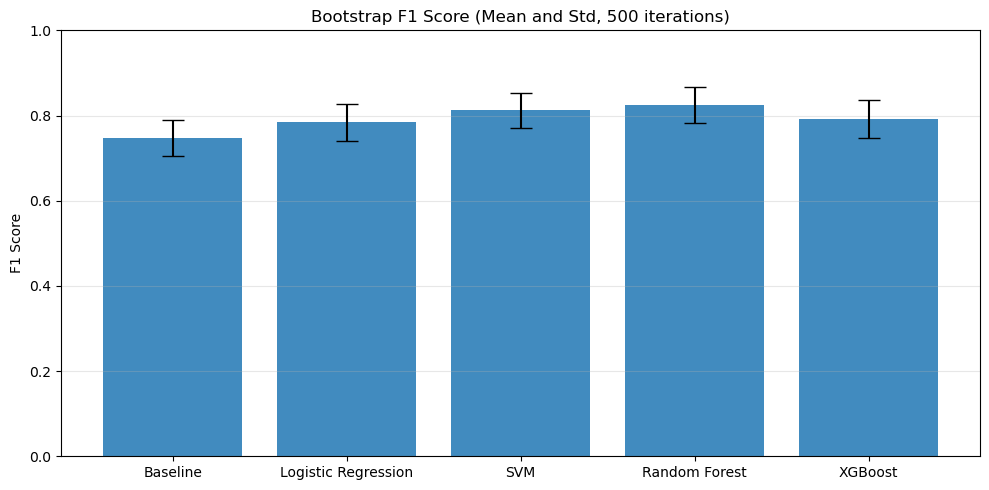

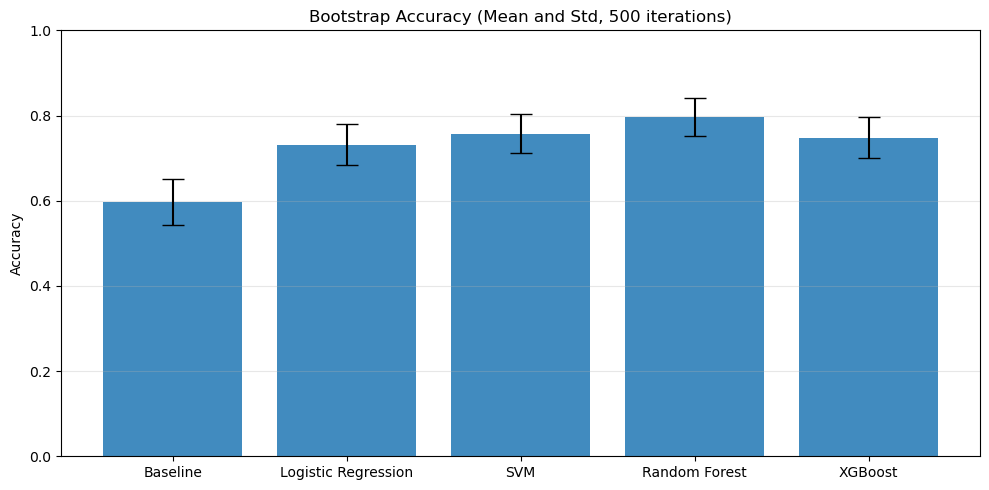

Baseline:
F1: mean = 0.747, std = 0.043
Acc: mean = 0.598, std = 0.054

Logistic Regression:
F1: mean = 0.785, std = 0.044
Acc: mean = 0.732, std = 0.048

SVM:
F1: mean = 0.812, std = 0.041
Acc: mean = 0.758, std = 0.046

Random Forest:
F1: mean = 0.825, std = 0.043
Acc: mean = 0.797, std = 0.045

XGBoost:
F1: mean = 0.792, std = 0.044
Acc: mean = 0.748, std = 0.048



In [247]:
class BaselineMajorityModel:
    def predict(self, X):
        return np.ones(len(X), dtype=int)

baseline_model = BaselineMajorityModel()

models = {
    "Baseline": baseline_model,
    "Logistic Regression": best_logreg,
    "SVM": best_svm,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
}

print("Bootstrapping all models (500 iterations each)")

bootstrap_results = {}

for name, model in models.items():
    f1_scores = []
    acc_scores = []

    for _ in range(500):
        X_sample, y_sample = resample(X_test, y_test, replace=True)
        y_pred = model.predict(X_sample)
        f1_scores.append(f1_score(y_sample, y_pred, zero_division=0))
        acc_scores.append(accuracy_score(y_sample, y_pred))

    bootstrap_results[name] = {
        "f1": np.array(f1_scores),
        "acc": np.array(acc_scores)
    }


model_names = list(bootstrap_results.keys())

f1_means = [bootstrap_results[m]["f1"].mean() for m in model_names]
f1_stds = [bootstrap_results[m]["f1"].std() for m in model_names]

acc_means = [bootstrap_results[m]["acc"].mean() for m in model_names]
acc_stds = [bootstrap_results[m]["acc"].std() for m in model_names]


x = np.arange(len(model_names))
plt.figure(figsize=(10, 5))
plt.bar(x, f1_means, yerr=f1_stds, capsize=8, alpha=0.85)
plt.xticks(x, model_names)
plt.title("Bootstrap F1 Score (Mean and Std, 500 iterations)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

x = np.arange(len(model_names))
plt.figure(figsize=(10, 5))
plt.bar(x, acc_means, yerr=acc_stds, capsize=8, alpha=0.85)
plt.xticks(x, model_names)
plt.title("Bootstrap Accuracy (Mean and Std, 500 iterations)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

for i, name in enumerate(model_names):
    print(f"{name}:")
    print(f"F1: mean = {f1_means[i]:.3f}, std = {f1_stds[i]:.3f}")
    print(f"Acc: mean = {acc_means[i]:.3f}, std = {acc_stds[i]:.3f}")
    print()


=== Confusion Matrices ===


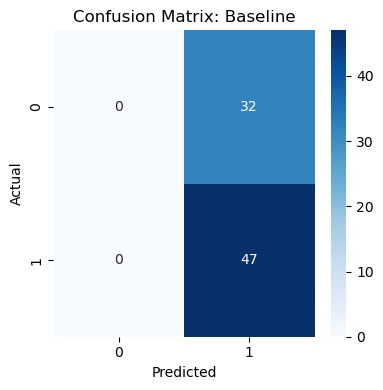

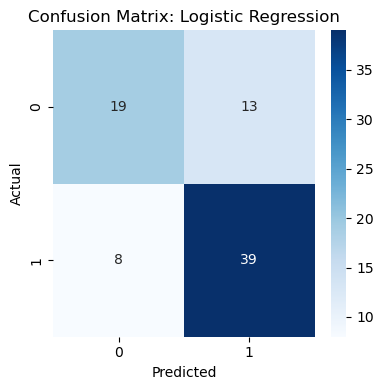

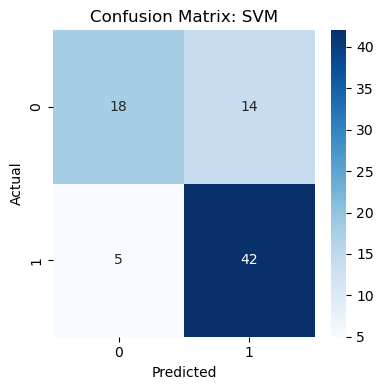

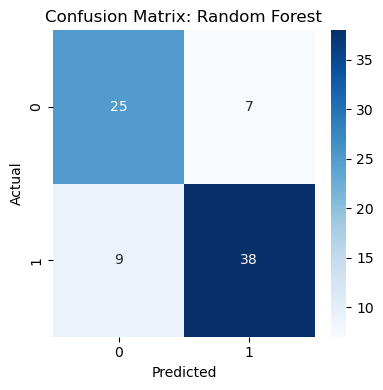

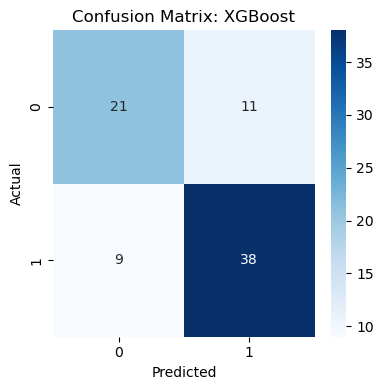

In [248]:
baseline_model = BaselineMajorityModel()
models = {
    "Baseline": baseline_model,
    "Logistic Regression": best_logreg,
    "SVM": best_svm,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
}

def plot_confusion_matrix_for_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

print("=== Confusion Matrices ===")
for name, model in models.items():
    plot_confusion_matrix_for_model(model, X_test, y_test, name)

pre_fitted = best_logreg.named_steps["pre"]
feature_names = pre_fitted.get_feature_names_out()

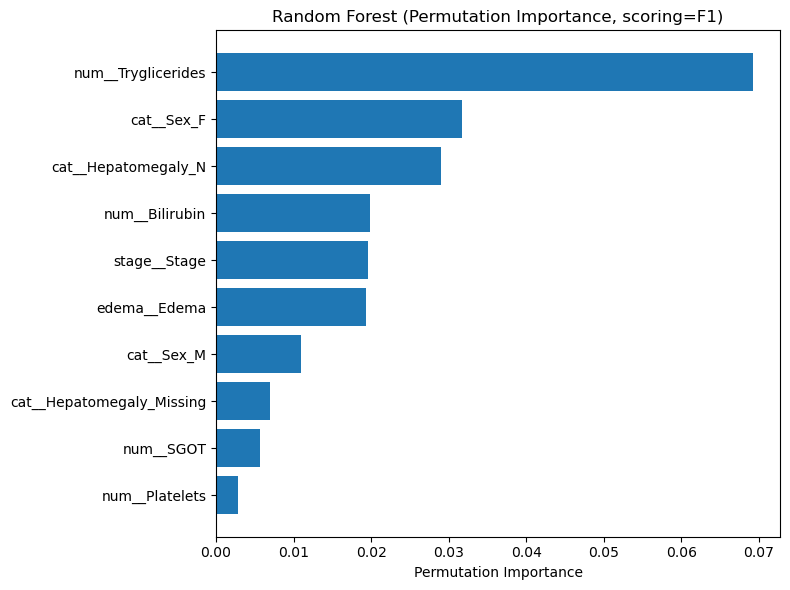


Top 10 features for Random Forest (Permutation Importance, scoring=F1):
num__Tryglicerides                        0.0693
cat__Sex_F                                0.0317
cat__Hepatomegaly_N                       0.0291
num__Bilirubin                            0.0199
stage__Stage                              0.0195
edema__Edema                              0.0193
cat__Sex_M                                0.0110
cat__Hepatomegaly_Missing                 0.0070
num__SGOT                                 0.0057
num__Platelets                            0.0028
------------------------------------------------------------


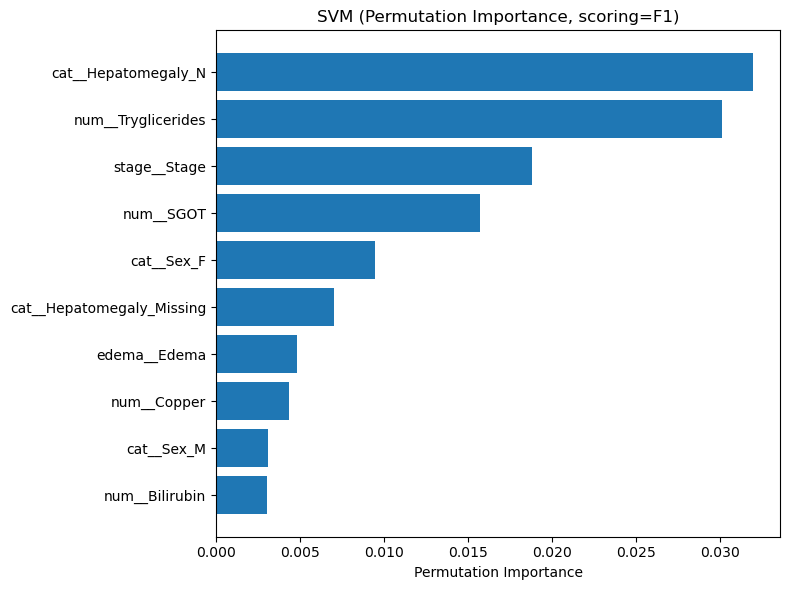


Top 10 features for SVM (Permutation Importance, scoring=F1):
cat__Hepatomegaly_N                       0.0320
num__Tryglicerides                        0.0301
stage__Stage                              0.0188
num__SGOT                                 0.0157
cat__Sex_F                                0.0094
cat__Hepatomegaly_Missing                 0.0070
edema__Edema                              0.0048
num__Copper                               0.0043
cat__Sex_M                                0.0031
num__Bilirubin                            0.0031
------------------------------------------------------------


In [249]:
preprocessor = best_rf.named_steps["pre"]
feature_names = preprocessor.get_feature_names_out()

def plot_feature_importance(names, values, title, top_k=10):
    idx_sorted = np.argsort(values)[::-1]
    idx_top = idx_sorted[:top_k]

    top_names = names[idx_top]
    top_values = values[idx_top]

    plt.figure(figsize=(8, 6))
    plt.barh(top_names[::-1], top_values[::-1])
    plt.title(title)
    plt.xlabel("Permutation Importance")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_k} features for {title}:")
    for n, v in zip(top_names, top_values):
        print(f"{n:40s}  {v:.4f}")
    print("-" * 60)

result_rf = permutation_importance(
    best_rf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=0,
    n_jobs=-1,
    scoring="f1"
)

rf_importance = result_rf.importances_mean

plot_feature_importance(
    np.array(feature_names),
    rf_importance,
    title="Random Forest (Permutation Importance, scoring=F1)",
    top_k=10
)

result_svm = permutation_importance(
    best_svm,
    X_test,
    y_test,
    n_repeats=20,
    random_state=0,
    n_jobs=-1,
    scoring="f1"
)

svm_importance = result_svm.importances_mean

plot_feature_importance(
    np.array(feature_names),
    svm_importance,
    title="SVM (Permutation Importance, scoring=F1)",
    top_k=10
)


In [250]:
pre = best_rf.named_steps["pre"]
rf_model = best_rf.named_steps["clf"]

print("RF feature_importances_ (top 10):")
fi = rf_model.feature_importances_
feature_names = pre.get_feature_names_out()
idx_sorted = fi.argsort()[::-1]

for i in idx_sorted[:10]:
    print(f"{feature_names[i]:40s}  {fi[i]:.4f}")


RF feature_importances_ (top 10):
num__Bilirubin                            0.1666
num__Copper                               0.1189
num__Prothrombin                          0.1029
num__Age                                  0.0878
num__SGOT                                 0.0710
num__Albumin                              0.0689
num__Alk_Phos                             0.0625
num__Cholesterol                          0.0610
num__Tryglicerides                        0.0529
num__Platelets                            0.0498


  0%|          | 0/1 [00:00<?, ?it/s]

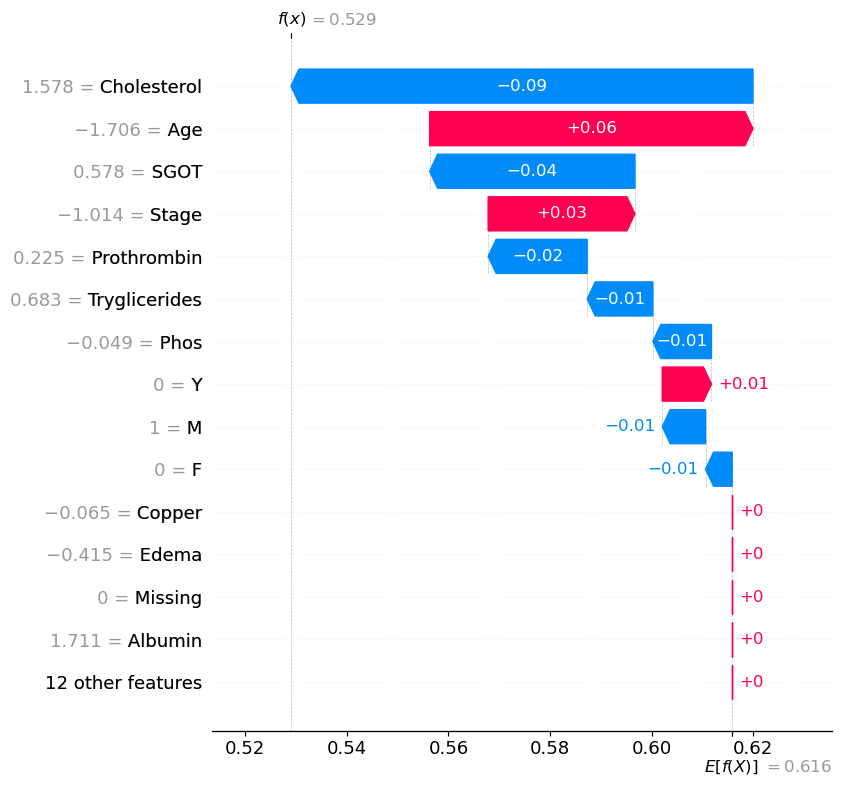

Drug             D-penicillamine
Age                        12227
Sex                            M
Ascites                        N
Hepatomegaly                   N
Spiders                        N
Edema                          N
Bilirubin                    1.6
Cholesterol                660.0
Albumin                     4.22
Copper                      94.0
Alk_Phos                  1857.0
SGOT                       151.9
Tryglicerides              155.0
Platelets                  337.0
Prothrombin                 11.0
Stage                        2.0
Name: 89, dtype: object


In [251]:
pre = best_rf.named_steps["pre"]
rf_model = best_rf.named_steps["clf"]

X_train_trans = pre.transform(X_train)
X_test_trans = pre.transform(X_test)

if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

raw_feature_names = pre.get_feature_names_out()
pretty_names = []
for name in raw_feature_names:
    if "__" in name:
        name = name.split("__", 1)[1]
    parts = name.split("_", 1)

    if len(parts) == 1:
        pretty_names.append(name)
        continue

    prefix, rest = parts
    if prefix in ("num", "ord"):
        pretty_names.append(rest)
    elif prefix == "cat" and "_" in rest:
        feat, val = rest.split("_", 1)
        pretty_names.append(f"{feat} = {val}")
    else:
        pretty_names.append(rest)

pretty_names = np.array(pretty_names)

n_bg = min(100, X_train_trans.shape[0])
bg_idx = np.random.RandomState(0).choice(X_train_trans.shape[0], size=n_bg, replace=False)
background = X_train_trans[bg_idx]

explainer = shap.KernelExplainer(lambda X: rf_model.predict_proba(X)[:, 1], background)

idx = 13
x_row_trans = X_test_trans[idx:idx+1]

values = explainer.shap_values(x_row_trans)[0]
base_value = explainer.expected_value

exp = shap.Explanation(
    values=values,
    base_values=base_value,
    data=x_row_trans[0],
    feature_names=pretty_names
)

shap.plots.waterfall(exp, max_display=15)
print(X_test.iloc[idx])


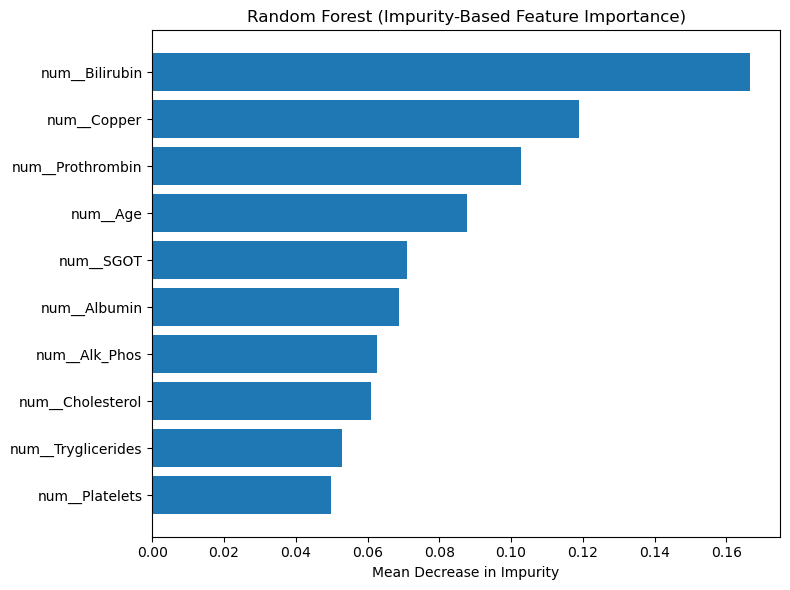


Top 10 features (RF impurity importance):
num__Bilirubin                            0.1666
num__Copper                               0.1189
num__Prothrombin                          0.1029
num__Age                                  0.0878
num__SGOT                                 0.0710
num__Albumin                              0.0689
num__Alk_Phos                             0.0625
num__Cholesterol                          0.0610
num__Tryglicerides                        0.0529
num__Platelets                            0.0498
------------------------------------------------------------


In [252]:
rf_clf = best_rf.named_steps["clf"]
rf_importance_impurity = rf_clf.feature_importances_

def plot_rf_impurity_importance(names, values, top_k=10):
    idx_sorted = np.argsort(values)[::-1]
    idx_top = idx_sorted[:top_k]

    top_names = names[idx_top]
    top_values = values[idx_top]

    plt.figure(figsize=(8, 6))
    plt.barh(top_names[::-1], top_values[::-1])
    plt.xlabel("Mean Decrease in Impurity")
    plt.title("Random Forest (Impurity-Based Feature Importance)")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_k} features (RF impurity importance):")
    for n, v in zip(top_names, top_values):
        print(f"{n:40s}  {v:.4f}")
    print("-" * 60)

plot_rf_impurity_importance(
    np.array(feature_names),
    rf_importance_impurity,
    top_k=10
)


  0%|          | 0/79 [00:00<?, ?it/s]

Top 15 features by mean(|SHAP|):
                feature  mean_abs_shap
0        num__Bilirubin       0.080296
1      num__Prothrombin       0.059844
2           num__Copper       0.055638
3              num__Age       0.040694
4          stage__Stage       0.020583
5      num__Cholesterol       0.017571
6          num__Albumin       0.017066
7             num__SGOT       0.015370
8         num__Alk_Phos       0.013044
9   cat__Hepatomegaly_Y       0.012303
10   num__Tryglicerides       0.010279
11       num__Platelets       0.007371
12  cat__Hepatomegaly_N       0.004731
13         edema__Edema       0.003910
14       cat__Ascites_Y       0.003348


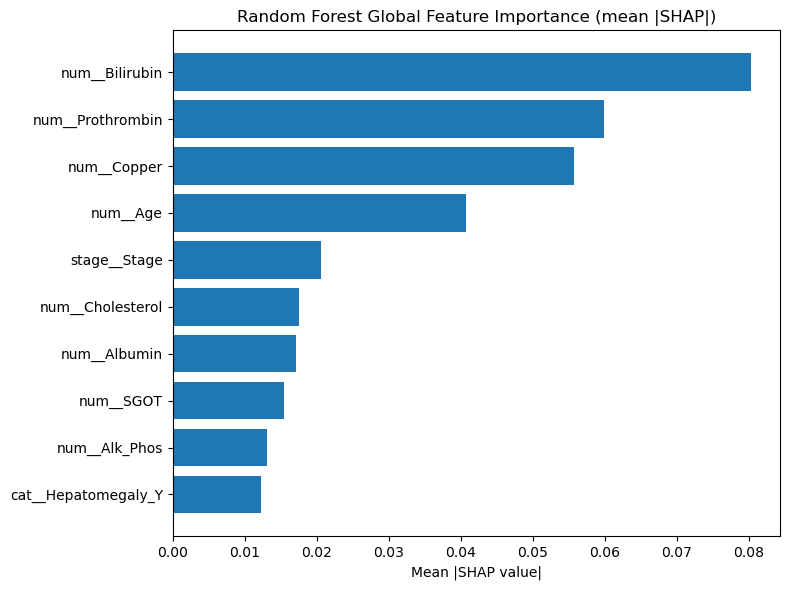

In [253]:
pre = best_rf.named_steps["pre"]
rf_model = best_rf.named_steps["clf"]

X_train_trans = pre.transform(X_train)
X_test_trans = pre.transform(X_test)

if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

feature_names = pre.get_feature_names_out()

n_bg = min(100, X_train_trans.shape[0])
rng = np.random.RandomState(0)
bg_idx = rng.choice(X_train_trans.shape[0], size=n_bg, replace=False)
background = X_train_trans[bg_idx]

explainer = shap.KernelExplainer(
    lambda X: rf_model.predict_proba(X)[:, 1],
    background
)

n_eval = min(200, X_test_trans.shape[0])
eval_idx = rng.choice(X_test_trans.shape[0], size=n_eval, replace=False)
X_eval = X_test_trans[eval_idx]

shap_values = explainer.shap_values(X_eval)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

global_shap_df = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("Top 15 features by mean(|SHAP|):")
print(global_shap_df.head(15))

top_k = 10
plot_df = global_shap_df.head(top_k).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["mean_abs_shap"])
plt.xlabel("Mean |SHAP value|")
plt.title("Random Forest Global Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()


In [256]:
df = pd.read_csv("data/cirrhosis.csv")
df = df[df['Status'] != "CL"]
Xt = preprocess.fit_transform(df)
feature_names = preprocess.get_feature_names_out()
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()
df_preprocessed = pd.DataFrame(Xt, columns=feature_names, index=df.index)
df_preprocessed.to_csv("entire_data_preprocessed.csv", index=True)

print("\nShape:", df_preprocessed.shape)
display(df_preprocessed.head())


Shape: (393, 26)


,num__Age,num__Bilirubin,num__Cholesterol,num__Albumin,num__Copper,num__Alk_Phos,num__SGOT,num__Tryglicerides,num__Platelets,num__Prothrombin,...,cat__Hepatomegaly_Y,cat__Spiders_Missing,cat__Spiders_N,cat__Spiders_Y,cat__Ascites_Missing,cat__Ascites_N,cat__Ascites_Y,cat__Drug_D-penicillamine,cat__Drug_Missing,cat__Drug_Placebo
0,0.717291,2.538635,-0.517180,-2.123108,0.814471,-0.140425,0.322941,0.899991,-0.664908,1.391485,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.493963,-0.471646,-0.298447,1.517589,-0.571479,2.844288,-0.164236,-0.645029,-0.341184,-0.150130,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.806247,-0.404252,-0.970651,-0.042710,1.548209,-0.772405,-0.511621,-1.252001,-1.072175,1.198783,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.329697,-0.314393,-0.607874,-2.264954,-0.435601,2.174978,-1.218954,-0.571457,-0.738007,-0.439183,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5,1.438955,-0.539041,-0.586534,1.139335,-0.625830,-0.547374,-0.573440,-1.104856,-0.277031,0.235274,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [257]:
import os
import joblib

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
models = {
    "baseline": baseline_model,
    "logistic_regression": best_logreg,
    "svm": best_svm,
    "random_forest": best_rf,
    "xgboost": best_xgb,
}
for name, model in models.items():
    path = os.path.join(RESULTS_DIR, f"{name}.joblib")
    joblib.dump(model, path)
    print(f"Saved {name} --> {path}")


Saved baseline --> results/baseline.joblib
Saved logistic_regression --> results/logistic_regression.joblib
Saved svm --> results/svm.joblib
Saved random_forest --> results/random_forest.joblib
Saved xgboost --> results/xgboost.joblib
